In [1]:
import pandas as pd
import numpy as np
import cnvutils
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
CHROMOSOME = '8'

In [3]:
def read_cancer_type_tcga(cancer_type):
    
    df = pd.read_csv(
        os.path.join("..", cancer_type, "Gistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz"), 
        sep="\t"
    )
    return df

In [4]:
cnv = {
    'BRCA': read_cancer_type_tcga("brca"),
#     'CCRCC': ,
#     'COLON': ,
#     'ENDO': ,
#     'GBM': ,
#     'HNSCC': ,
#     'LSCC': ,
#     'LUAD': ,
#     'OVARIAN': 
}

In [5]:
gene_locations = cnvutils.get_gene_locations().reset_index(drop=False)
gene_locations = gene_locations.assign(
    Name=gene_locations["Name"].fillna("unknown"),
    Database_ID=gene_locations["Database_ID"].fillna("unknown")
).set_index(["Name", "Database_ID"])

In [6]:
def get_gain_counts(row):
    gain = len(row[row > 0])
    return gain

In [7]:
def get_loss_counts(row):
    loss = len(row[row < 0])
    return loss

In [8]:
cnv_8 = {}
for cancer_type in cnv.keys():
    
    df = cnv[cancer_type].copy()
    idx_split = df["Gene Symbol"].str.split("|", n=1, expand=True)
    df = df.drop(columns="Gene Symbol")
    idx_split = idx_split.fillna("unknown")
    df = df.assign(
        Name=idx_split[0],
        Database_ID=idx_split[1]
    )
    df = df.set_index(["Name", "Database_ID"])
    
    df['gain'] = df.apply(get_gain_counts, axis=1)
    df['loss'] = df.apply(get_loss_counts, axis=1)
    
    df = df.join(gene_locations)
    df = df[df.chromosome == CHROMOSOME]
    
    cnv_8[cancer_type] = df.melt(id_vars=['start_bp', 'end_bp'], value_vars=['gain', 'loss'], ignore_index=False)

In [9]:
cnv_8["BRCA"]

start_bp       end_bp variable  value
Name      Database_ID                                                
SNORA72   ENSG00000201944.1   98042086.0   98042217.0     gain    819
          ENSG00000201898.1   98042086.0   98042217.0     gain    806
          ENSG00000207249.1   98042086.0   98042217.0     gain    108
          ENSG00000206901.1   98042086.0   98042217.0     gain     86
          ENSG00000207084.1   98042086.0   98042217.0     gain    302
          ENSG00000200355.1   98042086.0   98042217.0     gain    334
ERICH1    unknown               614746.0     738106.0     gain    160
FBXO25    unknown               406428.0     477967.0     gain    161
OR4F21    unknown               166049.0     167043.0     gain    161
RPL23AP53 unknown               213186.0     232231.0     gain    161
TDRP      unknown               489792.0     545781.0     gain    161
ZNF596    unknown               232137.0     264703.0     gain    161
DLGAP2    unknown               737596.0    1708474.0     gain    160
CLN8      unknown              1755778.0    1801711.0     gain    159
MIR596    unknown              1817231.0    1817307.0     gain    159
ARHGEF10  unknown              1823926.0    1958641.0     gain    159
KBTBD11   unknown              1973677.0    2006936.0     gain    159
MYOM2     unknown              2045046.0    2165552.0     gain    158
CSMD1     unknown              2935353.0    4994972.0     gain    158
RNA5SP251 unknown              3700492.0    3700628.0     gain    152
RN7SL318P unknown              5142411.0    5142707.0     gain    152
RN7SKP159 unknown              5910945.0    5911236.0     gain    152
MCPH1     unknown              6406596.0    6648508.0     gain    151
ANGPT2    unknown              6499651.0    6563409.0     gain    149
AGPAT5    unknown              6708642.0    6761503.0     gain    150
MIR4659A  unknown              6745164.0    6745244.0     gain    150
XKR5      unknown              6808517.0    6835524.0     gain    149
DEFB1     unknown              6870592.0    6877936.0     gain    149
DEFA6     unknown              6924697.0    6926076.0     gain    149
DEFA4     unknown              6935820.0    6938306.0     gain    149
...                                  ...          ...      ...    ...
CPSF1     unknown            144393229.0  144409335.0     loss     69
CYHR1     unknown            144449582.0  144465677.0     loss     69
DGAT1     unknown            144314584.0  144326910.0     loss     69
FBXL6     unknown            144355431.0  144359376.0     loss     69
FOXH1     unknown            144473412.0  144475849.0     loss     69
GPT       unknown            144502973.0  144507174.0     loss     69
HSF1      unknown            144291591.0  144314720.0     loss     69
KIFC2     unknown            144466043.0  144474202.0     loss     69
LRRC14    unknown            144517992.0  144525172.0     loss     69
LRRC24    unknown            144522388.0  144527033.0     loss     69
MFSD3     unknown            144509070.0  144511213.0     loss     69
MIR1234   unknown            144400086.0  144400165.0     loss     69
MIR939    unknown            144394149.0  144394230.0     loss     69
PPP1R16A  unknown            144477969.0  144502121.0     loss     69
RECQL4    unknown            144511288.0  144517845.0     loss     69
RN7SL395P unknown            144785298.0  144785588.0     loss     69
RPL8      unknown            144789765.0  144792587.0     loss     69
SCRT1     unknown            144330565.0  144336482.0     loss     69
SLC39A4   unknown            144409742.0  144416895.0     loss     69
SLC52A2   unknown            144354135.0  144361272.0     loss     69
TMEM249   unknown            144352219.0  144354914.0     loss     69
TONSL     unknown            144428775.0  144444440.0     loss     69
VPS28     unknown            144423601.0  144428563.0     loss     69
ZNF16     unknown            144930358.0  144950888.0     loss     69
ZNF250    unknown            144876497.0  

In [10]:
# I was not able to find a good library for creating a visual of a chromosome
# with their banding patterns, so I wrote this function to do it for me.

# ideogram_data = pd.read_csv('NCBI_ideogram.csv') #cytoband infromation from NCBI
ideogram_data = cnvutils.get_cytoband_info()
chromo8 = ideogram_data[ideogram_data['#chromosome'] == CHROMOSOME]
colors = []
sections = list()

for index, row in chromo8.iterrows():
    sections.append((row['bp_start'], row['bp_stop']-row['bp_start']))
    
    if row['stain'] == 'gneg':
        colors.append('white')
    elif row['stain'] == 'gpos':
        if row['density'] == 25.0:
            colors.append('lightgray')
        elif row['density'] == 50.0:
            colors.append('gray')
        elif row['density'] == 75.0:
            colors.append('darkgray')
        else:
            colors.append('black')
    elif row['stain'] == 'acen':
        colors.append('red')
    else:
        colors.append('lightgray')

BRCA


Text(0.07, 0.5, 'Number of Samples')

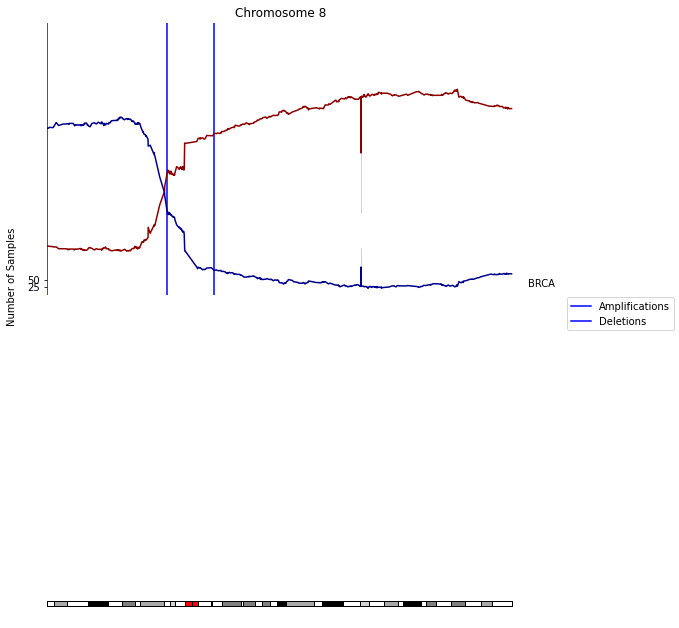

In [11]:
count = 0
end_bp = sections[len(sections) - 1][0] + sections[len(sections) - 1][1]
fig, axs = plt.subplots(nrows=len(cnv_8) + 1, sharex=True, sharey=True, num=0, figsize=(10,11), )
title = f'Chromosome 8'
fig.suptitle(title, y=0.9, x=0.45)
plt.xlim(0,175138636)
plt.xlim(0,end_bp + (end_bp/5))
plt.ylim(0, 900)
for cancer in cnv_8.keys():
    print(cancer)
    frame = cnv_8[cancer]
    axs[count].get_xaxis().set_visible(False)
    axs[count].set_yticks([25,50])
    axs[count].set_frame_on(False)
    axs[count].text(end_bp + 5000000, 25, cancer)
    # Testing out the location event stuff
    axs[count].axvline(52110839, 0, 75, color='b')
    axs[count].axvline(202660, 0, 75, color='b')
    axs[count].axvline(37421341, 0, 75, color='b')
    sns.lineplot(x="start_bp", y="value", hue="variable", palette=['darkred', 'darkblue'], data=frame, ax=axs[count], legend=False)
    axs[count].set_ylabel("")
    count += 1
plt.broken_barh(sections, (50,15), facecolors=colors, edgecolor="black")
plt.axis('off')
fig.legend(labels=("Amplifications", "Deletions"), loc='center right')
fig.text(0.07, 0.5, "Number of Samples", rotation="vertical")

In [12]:
dfs = list()
for cancer in cnv_8.keys():
    df = cnv_8[cancer]
    df['cancer'] = cancer
    dfs.append(df)
cnv_8_long = pd.concat(dfs)

In [13]:
cnv_8_long

start_bp       end_bp variable  value cancer
Name      Database_ID                                                       
SNORA72   ENSG00000201944.1   98042086.0   98042217.0     gain    819   BRCA
          ENSG00000201898.1   98042086.0   98042217.0     gain    806   BRCA
          ENSG00000207249.1   98042086.0   98042217.0     gain    108   BRCA
          ENSG00000206901.1   98042086.0   98042217.0     gain     86   BRCA
          ENSG00000207084.1   98042086.0   98042217.0     gain    302   BRCA
          ENSG00000200355.1   98042086.0   98042217.0     gain    334   BRCA
ERICH1    unknown               614746.0     738106.0     gain    160   BRCA
FBXO25    unknown               406428.0     477967.0     gain    161   BRCA
OR4F21    unknown               166049.0     167043.0     gain    161   BRCA
RPL23AP53 unknown               213186.0     232231.0     gain    161   BRCA
TDRP      unknown               489792.0     545781.0     gain    161   BRCA
ZNF596    unknown               232137.0     264703.0     gain    161   BRCA
DLGAP2    unknown               737596.0    1708474.0     gain    160   BRCA
CLN8      unknown              1755778.0    1801711.0     gain    159   BRCA
MIR596    unknown              1817231.0    1817307.0     gain    159   BRCA
ARHGEF10  unknown              1823926.0    1958641.0     gain    159   BRCA
KBTBD11   unknown              1973677.0    2006936.0     gain    159   BRCA
MYOM2     unknown              2045046.0    2165552.0     gain    158   BRCA
CSMD1     unknown              2935353.0    4994972.0     gain    158   BRCA
RNA5SP251 unknown              3700492.0    3700628.0     gain    152   BRCA
RN7SL318P unknown              5142411.0    5142707.0     gain    152   BRCA
RN7SKP159 unknown              5910945.0    5911236.0     gain    152   BRCA
MCPH1     unknown              6406596.0    6648508.0     gain    151   BRCA
ANGPT2    unknown              6499651.0    6563409.0     gain    149   BRCA
AGPAT5    unknown              6708642.0    6761503.0     gain    150   BRCA
MIR4659A  unknown              6745164.0    6745244.0     gain    150   BRCA
XKR5      unknown              6808517.0    6835524.0     gain    149   BRCA
DEFB1     unknown              6870592.0    6877936.0     gain    149   BRCA
DEFA6     unknown              6924697.0    6926076.0     gain    149   BRCA
DEFA4     unknown              6935820.0    6938306.0     gain    149   BRCA
...                                  ...          ...      ...    ...    ...
CPSF1     unknown            144393229.0  144409335.0     loss     69   BRCA
CYHR1     unknown            144449582.0  144465677.0     loss     69   BRCA
DGAT1     unknown            144314584.0  144326910.0     loss     69   BRCA
FBXL6     unknown            144355431.0  144359376.0     loss     69   BRCA
FOXH1     unknown            144473412.0  144475849.0     loss     69   BRCA
GPT       unknown            144502973.0  144507174.0     loss     69   BRCA
HSF1      unknown            144291591.0  144314720.0     loss     69   BRCA
KIFC2     unknown            144466043.0  144474202.0     loss     69   BRCA
LRRC14    unknown            144517992.0  144525172.0     loss     69   BRCA
LRRC24    unknown            144522388.0  144527033.0     loss     69   BRCA
MFSD3     unknown            144509070.0  144511213.0     loss     69   BRCA
MIR1234   unknown            144400086.0  144400165.0     loss     69   BRCA
MIR939    unknown            144394149.0  144394230.0     loss     69   BRCA
PPP1R16A  unknown            144477969.0  144502121.0     loss     69   BRCA
RECQL4    unknown            144511288.0  144517845.0     loss     69   BRCA
RN7SL395P unknown            144785298.0  144785588.0     loss     69   BRCA
RPL8      unknown            144789765.0  144792587.0     loss     69   BRCA
SCRT1     unknown            144330565.0  144336482.0     loss     69   BRCA
SLC39A4   unknown            144409742.0  144416895.0     loss     69   BRCA
SLC52A2   unknown           

In [14]:
cnv_8_long = cnv_8_long.sort_values(['cancer', 'start_bp'])
cnv_8_long.reset_index(inplace=True)
cnv_8_long.to_csv('cnv_counts.tsv', sep='\t')

In [15]:
cnv_8_long

,Name,Database_ID,start_bp,end_bp,variable,value,cancer
0,OR4F21,unknown,166049.0,167043.0,gain,161,BRCA
1,OR4F21,unknown,166049.0,167043.0,loss,551,BRCA
2,RPL23AP53,unknown,213186.0,232231.0,gain,161,BRCA
3,RPL23AP53,unknown,213186.0,232231.0,loss,551,BRCA
4,ZNF596,unknown,232137.0,264703.0,gain,161,BRCA
5,ZNF596,unknown,232137.0,264703.0,loss,551,BRCA
6,FBXO25,unknown,406428.0,477967.0,gain,161,BRCA
7,FBXO25,unknown,406428.0,477967.0,loss,551,BRCA
8,TDRP,unknown,489792.0,545781.0,gain,161,BRCA
9,TDRP,unknown,489792.0,545781.0,loss,551,BRCA


In [16]:
# g = sns.FacetGrid(cnv_8_long, row='cancer', hue='variable')
# g.map(sns.barplot,"Name","value")

In [17]:
# luad_cnv_8 = cnv_8['LUAD']
# luad_cnv_8_loss = luad_cnv_8[(luad_cnv_8.variable == 'loss')].sort_values('start_bp')

In [18]:
# list(luad_cnv_8_loss.value)

In [19]:
# luad_cnv_8 = cnv_8['LUAD']
# luad_cnv_8_loss = luad_cnv_8[(luad_cnv_8.variable == 'loss')].sort_values('start_bp')
# values = list(luad_cnv_8_loss.value)
# luad_loss_events = list()
# start = None
# for i in range(0, len(values)):
#     val = values[i]
#     if val > 20:
#         if start is None:
#             start = i
#     else:
#         if start is not None:
#             luad_loss_events.append((start, i))
#             start = None

In [20]:
# luad_loss_events

In [21]:
# luad_cnv_8_loss.iloc[2: 631]

In [22]:
for cancer in cnv_8.keys():
    df = cnv_8[cancer]
    df_loss = df[(df.variable == 'loss')].sort_values('start_bp')
    values = list(df_loss.value)
    loss_events = list()
    start = None
    for i in range(0, len(values)):
        val = values[i]
        if val > 20:
            if start is None:
                start = i
        else:
            if start is not None:
                loss_events.append((start, i))
                start = None
                
    event_locations = list()
    for event in loss_events:
        event_locations.append((df_loss.iloc[event[0]].start_bp, df_loss.iloc[event[1]].start_bp))
    print(cancer)
    print(event_locations)

BRCA
[(166049.0, 98042086.0)]
